<a href="https://colab.research.google.com/github/harmanpreet93/reinforcement-learning-COMP-767/blob/master/Continuous_Random_Walk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Continuous Random Walk**

In [0]:
import numpy as np
import random
from matplotlib import pyplot as plt

class RandomWalk:
  def __init__(self):
    '''
    As stated, the episode starts at state 0.5
    '''
    self.state = 0.5
  
  def step(self):
    '''
    At each step, the agent moves up or down by a uniformly 
    selected random step in the interval [-0.2, 0.2].
    '''
    n_step = random.uniform(-0.2, 0.2) 
    self.state += n_step
    return self.state

    
def generate_tiles(num_tiles, num_intervals):
  '''
  Generating multiple tiles and tilings
  Dividing the state space [0,1] into 10 equal sized intervals. 
  Also adding an additional interval in order to allow for an offset of the whole tiling. 
  Repeating this 10 times to obtain 10 different tilings each offset 
  by a different randomly selected fraction of the interval.
  '''
  tiling = []
  tiles = np.linspace(0, 1, num_intervals)[1:-1]
  tiling.append(tiles)
  for i in range(num_tiles-1):
    offset = random.uniform(0, 0.1)
    tiles = np.linspace(0, 1, num_intervals)[1:-1]+offset
    tiling.append(tiles)
  return tiling

tiling = generate_tiles(num_tiles=10, num_intervals=10+1)

In [0]:
def get_encoding(x):
  '''
  Get encoding for each continous value in the state space.
  Adding a feature corresponding to each interval that takes the value 1 
  when the state was within that tile, and 0 otherwise.
  Feature Vector = Num of tiles X Num of tilings
  '''
  final_encoding = np.array([])
  for tile in tiling:
    final_encoding = np.append(final_encoding, np.eye(10)[np.digitize(x, tile)])
  return final_encoding

def get_value(state, weight):
  '''
  Linear function approximator aproximator that gives V(terminal_state)=0 
  '''
  if state<0 or state>1:
    return 0
  state = get_encoding(state)
  state = state.reshape(-1, 1)
  weight = weight.reshape(-1, 1)
  return np.dot(state.T, weight).flatten()[0]

In [0]:
def algo(alpha, lamda):
  '''
  Semi Gradient TD Lamda with accumulating traces
  '''
  i = 0
  gamma = 1
  w = np.zeros(100)
  alpha = alpha/10
  while i<25:
    env = RandomWalk()
    E = np.zeros(100)

    while True:
      c_state = env.state
      n_state = env.step()
      # The reward rt is 0 everywhere except when the agent
      # terminates i.e. when either state 0 or 1 is exceeded 
      if n_state<=0 or n_state>=1:  reward = n_state
      else: reward = 0
      
      E = gamma*lamda*E + get_encoding(c_state)
      delta = reward + gamma*get_value(n_state, w) - get_value(c_state, w)
      w += alpha*delta*E

      # Reached terminal state reached.
      if reward!=0: break
    i+=1

  # Predicting values over 21 sampled values after 25 episodes of training.
  # and calculating the RMSE values 
  val = np.linspace(0,1,21)
  return np.sqrt(np.mean(np.square([get_value(x, w) for x in val]-val)))

Recording RMSE over different values of λ and α

In [0]:
# Running the experiment on 50 different seeds for each combination of λ and α values
# and averaging the results in the plots.
alphas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
lamdas = [0, 0.4, 0.7, 0.9, 0.95, 0.97, 0.99, 1]
main_rmse = []
for lamda in lamdas:
  mean_rmse = []
  for alpha in alphas:
    rmse_final = []
    for i in range(50):
      random.seed(i)
      rmse_final.append(algo(alpha, lamda))
    mean_rmse.append(rmse_final)
  main_rmse.append(mean_rmse)

Plotting RMSE for sampled 21 values averaged over 50 seeds after training for 25 episodes for each lambda and alpha value. Plotting the averaged result, and also showing the confidence interval (using the standard deviation from the all the runs).

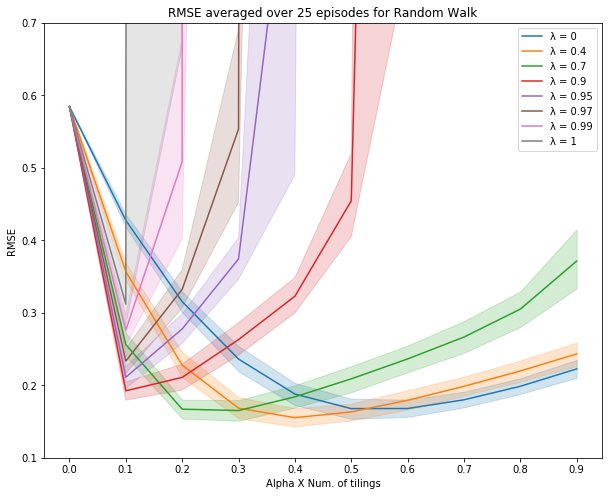

In [0]:
plt.figure(figsize=(10,8))
for i in range(len(lamdas)):
  df = pd.melt(pd.DataFrame(main_rmse[i]).T,
             var_name="alphas", value_name="rmse")
  df['alphas'] = df['alphas'].apply(lambda x: alphas[x])
  sns.lineplot(x='alphas', y='rmse', 
             data=df)
plt.xlabel('Alpha X Num. of tilings')
plt.ylabel('RMSE')
plt.ylim(0.1, 0.7)
plt.xticks(alphas)
plt.legend(["λ = "+str(x) for x in lamdas], loc="upper right");
plt.title("RMSE averaged over 25 episodes for Random Walk");

**Observations**

This is a policy evaluation (prediction) task and the performance measure used is RMSE (at the end of each episode, averaged over the first 25 episodes). As evident in the graph, for large $\lambda $ values, the RMSE shoots up with large alpha values as the weight increases. Moreover, as expected while increasing the $\lambda$ value, variance is increased in the graph and they become more unstable with higher alpha values. In empirical comparisons, bootstrapping methods usually perform much better than nonbootstrapping methods. Our results summarizes a collection of results  $\lambda $ from 0 (pure bootstrapping) to 1 (pure nonbootstrapping). In all cases, performance became much worse as $\lambda $ approached 1, the nonbootstrapping case. 


Since this is the backward view implemented with accumulating traces. If $\lambda $=0, then the trace at t is exactly the value gradient corresponding to $S_t$. Thus the TD($\lambda $) update reduce to TD(0). For larger values of $\lambda $, but still $\lambda $ < 1, more of the preceding states are changed, but each more temporally distant state is changed less because the corresponding eligibility trace is smaller, as suggested by the figure. We say that the earlier states are given less credit for the TD error. If $\lambda $ = 1, then the credit given to earlier states falls only by $\gamma $ per step. This turns out to be just the right thing to do to achieve Monte Carlo behavior. If $\lambda $ = 1 and $\gamma $ = 1, then the eligibility traces do not decay at all with time. In this case the method behaves like a Monte Carlo method for an undiscounted, episodic task.



Quoting the Book. "At this time it is unclear why methods that involve some bootstrapping perform so much better than pure nonbootstrapping methods. It could be that bootstrapping methods learn faster, or it could be that they actually learn something better than nonbootstrapping methods. The available results indicate that nonbootstrapping methods are better than bootstrapping methods at reducing MSE from the true value function, but reducing MSE is not necessarily the most important goal. Nothing quite that simple is going on with bootstrapping methods, but they do seem to do something right. We expect the understanding of these issues to improve as research continues."